In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm

import numpy as np
from scipy import integrate, interpolate

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit, vmap
from functools import partial

from astropy import units as u
from astropy import constants as c
from astropy.cosmology import Planck18 as cosmo
from hmf import Transfer

sys.path.append("../..")
from dm21cm.utils import load_h5_dict, save_h5_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("../../plotting/matplotlibrc")

Some of these are my choice. Some of these are hardcoded by `21cmFAST`.

In [2]:
rhoCrit0 = cosmo.critical_density(0).to(u.M_sun / u.Mpc**3).value # [Msun / Mpc^3]
rho_m0 = cosmo.Om0 * rhoCrit0 # [Msun / Mpc^3]

# 21cmFAST Definitions for Critical Collapse
SHETH_a = 0.73
SHETH_A = 0.353
SHETH_p = 0.175
Deltac = 1.68

# Default Duty Cycle Parametrization
M_TURN = 5.012e+08
M_MIN = 1e0

# 1. Window functions

Sphere:

$$W(\vec k, R)=\int d^3x~e^{-i\vec k\vec x} \frac{3}{4\pi R^3} = \frac{3(\sin(k R)-kR\cos(kR))}{(kR)^3}$$
Normalization
$$W(0, R)=1$$

Cube:

$$W(\vec k, R)=\left(\int_{-R}^R dx~e^{-i k_x x} \frac{1}{2R}\right)(x\rightarrow y)(x\rightarrow z)=\frac{\sin(k_x R)}{k_x R}\frac{\sin(k_y R)}{k_y R}\frac{\sin(k_z R)}{k_z R}$$
Normalization
$$W(0, R)=1$$

In [3]:
# I took these definitions from 21cmFAST. 
def MtoR(M):
    return (3*M / (4*jnp.pi * rho_m0)) ** (1/3)

def RtoM(R):
    return 4*jnp.pi * rho_m0 * R**3 / 3

# This is the top-hat window function. I took this from 21cmFAST
def W(k, R):
    kR = k * R
    return jnp.where(kR >= 1e-4, 3.0 * (jnp.sin(kR) / kR**3 - jnp.cos(kR) / kR**2), 0.0)

# This is the derivative of the top-hat window function with respect to R. I took this from 21cmFAST
def dWdR(k, R):
    kR = k * R
    return jnp.where(k >= 1e-10, (9 * jnp.cos(kR) * k / kR**3) + (3 * jnp.sin(kR) * (1 - 3 / (kR * kR)) / (kR * R)), 0.0)
    
#===== Cube =====
# Side length = 2R
def MtoR_cube(M):
    return (M / rho_m0) ** (1/3) / 2

def RtoM_cube(R):
    return 8 * rho_m0 * R**3

def Wi_cube(ki, R):
    kiR = ki * R
    return jnp.where(kiR >= 1e-10, jnp.sin(kiR) / (kiR), 0.0)

def W_cube(kx, ky, kz, R):
    return Wi_cube(kx, R) * Wi_cube(ky, R) * Wi_cube(kz, R)

def dWidR_cube(ki, R):
    kiR = ki * R
    return jnp.where(ki >= 1e-10, (kiR*jnp.cos(kiR) - jnp.sin(kiR)) / (kiR*R), 0.0)

def dWdR_cube(kx, ky, kz, R):
    return dWidR_cube(kx, R) * Wi_cube(ky, R) * Wi_cube(kz, R) + \
        Wi_cube(kx, R) * dWidR_cube(ky, R) * Wi_cube(kz, R) + \
        Wi_cube(kx, R) * Wi_cube(ky, R) * dWidR_cube(kz, R)

In [4]:
class CubeIntegrator:
    """Abstract cube integration calss"""

    def __init__(self, k, res=None, use_tqdm=False):
        self.res = res
        if self.res:
            self.k = jnp.geomspace(k[0], k[-1], self.res)
        else:
            self.k = jnp.asarray(k)
        self.lnk = jnp.log(self.k)
        self.use_tqdm = use_tqdm

    def integrand(self, kx, ky, kz, R):
        pass
    
    @partial(vmap, in_axes=(None, None, 0, None))
    def integrand_2(self, kx, ky, R):
        return jnp.trapz(self.k * self.integrand(kx, ky, self.k, R), self.lnk)
    
    @partial(jit, static_argnums=(0,))
    def integrand_1(self, kx, R):
        return jnp.trapz(self.k * self.integrand_2(kx, self.k, R), self.lnk)
    
    def integral(self, R):
        integrand = []
        k_iter = tqdm(self.k) if self.use_tqdm else self.k
        for k in k_iter:
            integrand.append(self.integrand_1(k, R))
        integrand = jnp.asarray(integrand)
        return jnp.trapz(self.k * integrand, self.lnk) * 8 # eight octants

# 2. Generating and normalize power spectrum from EH

In [5]:
tr = Transfer(cosmo_model=cosmo, transfer_model='EH', z=0)

# Doing the Sigma8 Normalization
interp_k = tr.k * cosmo.h # to u without `h`
interp_T = tr.transfer_function / np.amax(tr.transfer_function) # normalized
interp_P = interp_k**2 * interp_T**2 * interp_k**cosmo.to_format('mapping')['meta']['n']

# Defining an interpolated Power Spectrum that must be normalized to match Sigma8
k2P_unnorm = interpolate.CubicSpline(interp_k, interp_P)

Radius_8 = 8.0/cosmo.h
integrand = lambda logk: np.exp(logk)* k2P_unnorm(np.exp(logk)) * W(np.exp(logk), Radius_8)**2
result = integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)
sigma_norm = cosmo.to_format('mapping')['meta']['sigma8']/np.sqrt(result[0])
# Should be: sigma_norm = 2*np.pi**2 * cosmo.to_format('mapping')['meta']['sigma8']/np.sqrt(result[0])

# Redefining the Power Spectrum to be consistent with Sigma8
#PowerSpectrum = interpolate.CubicSpline(interp_k, sigma_norm**2*interp_P)
interp_k = jnp.asarray(interp_k)
interp_P = jnp.asarray(interp_P)
def k2P(k):
    """This k^2 P(k) carries some normalization such that int dk k2P(k) W(k, R)^2 = sigma^2."""
    return jnp.interp(k, interp_k, sigma_norm**2*interp_P)

In [6]:
# sigma_8^2
print(cosmo.to_format('mapping')['meta']['sigma8']**2)

# sphere trapz
k = jnp.geomspace(interp_k[0], interp_k[-1], 10000)
print(float(jnp.trapz(k * k2P(k) * W(k, Radius_8)**2, np.log(k))))

0.6564240400000001
0.6563394224615211


In `Transfer(z=0)`, let $T=$ `np.exp(self._unnormalised_lnT)`. $k=$ `self.k`. $n=$ `self.n`.

`self.power` $=P(k)=$ `self._normalisation**2` $k^n\,T^2$ \
`self.delta_k` $=\Delta^2(k)=k^3 * P(k) / (2 \pi)$

$$\sigma^2_8=\frac{1}{2\pi^2}\int dk\, k^2 P(k) W(k, R)^2$$

Here:

`self.transfer_function` $\propto T$

`interp_P` $= C k^2 \cdot k^{n'} \,T^2=C k^2 P(k)$, where $C$ is a unknown normalization. \
But it doesn't matter, we only care that for some normalization $C$,
$$\sigma^2_8 \equiv \int dk~ \Big(C k^2P(k)\Big) W(k, R)^2$$
So that later $\sigma^2(M)$ can be obtained in the exact same way.
Here `k2P` is $C k^2P(k)$ with unknown normalization $C$.

## 2.1 Check cube $\sigma_8$ is not crazy

$$\sigma^2 = \int dk~ \Big(C k^2P(k)\Big) W_\circ(k, R)^2 = \int d^3\vec k~ \frac{1}{4\pi |\vec k|^2}\Big(C |\vec k|^2P(|\vec k|)\Big) W_\square(\vec k, R)^2$$

In [7]:
class CISigmaSq (CubeIntegrator):
    def integrand(self, kx, ky, kz, R):
        k = jnp.sqrt(kx**2 + ky**2 + kz**2)
        return k2P(k) / (4*jnp.pi*k**2) * W_cube(kx, ky, kz, R)**2

In [8]:
# convergence
res_s = 2**np.arange(6, 12)
intg_s = []
for res in res_s:
    print(f"res = {res}")
    ci = CISigmaSq(interp_k, res=res, use_tqdm=True)
    intg_s.append(ci.integral(R=Radius_8))
intg_s = jnp.asarray(intg_s)

res = 64


100%|██████████| 64/64 [00:00<00:00, 124.59it/s]


res = 128


100%|██████████| 128/128 [00:00<00:00, 131.40it/s]


res = 256


100%|██████████| 256/256 [00:00<00:00, 419.59it/s]


res = 512


100%|██████████| 512/512 [00:00<00:00, 712.50it/s]


res = 1024


100%|██████████| 1024/1024 [00:01<00:00, 839.89it/s]


res = 2048


100%|██████████| 2048/2048 [00:07<00:00, 279.30it/s]


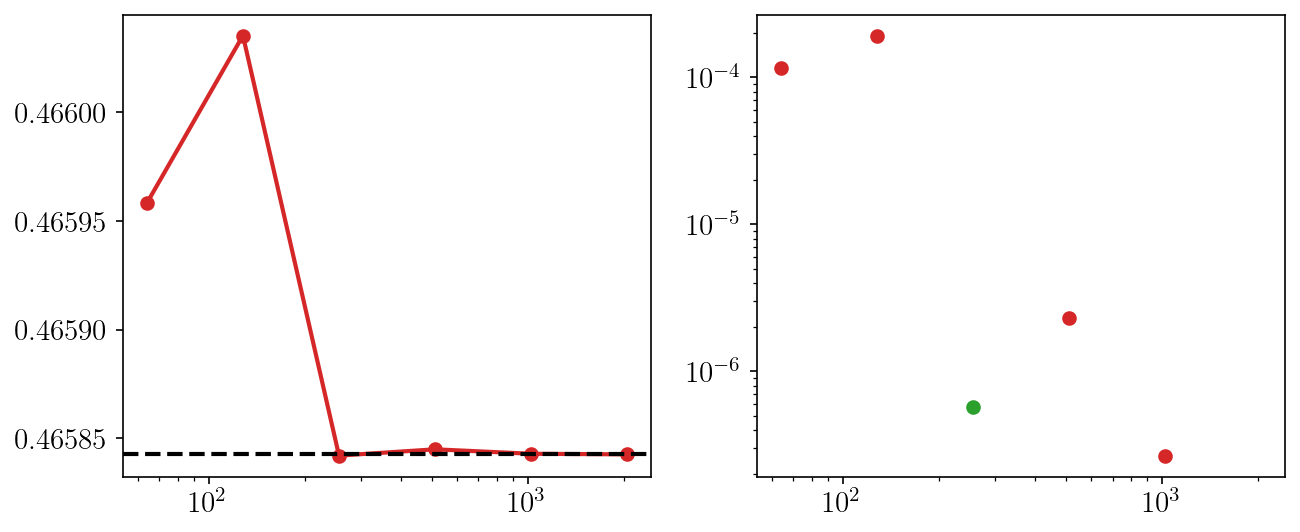

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(res_s, intg_s, 'o-')
axs[0].axhline(intg_s[-1], color='k', linestyle='--')
axs[0].set(xscale='log')

axs[1].plot(res_s, (intg_s-intg_s[-1]), 'o')
axs[1].plot(res_s, -(intg_s-intg_s[-1]), 'o')
axs[1].set(xscale='log', yscale='log');

In [8]:
ci = CISigmaSq(interp_k, res=1024, use_tqdm=False)
print(' cube in sphere', ci.integral(R=Radius_8/np.sqrt(3)))
print('         sphere', cosmo.to_format('mapping')['meta']['sigma8']**2)
print('Vcube = Vsphere', ci.integral(R=np.cbrt(np.pi/6) * Radius_8))
print('sphere in cube', ci.integral(R=Radius_8))

 cube in sphere 0.9795254402452758
         sphere 0.6564240400000001
Vcube = Vsphere 0.632314514279553
sphere in cube 0.4658429450395703


In [16]:
np.log10(RtoM(Radius_8))

14.435231992517188

In [14]:
print(Radius_8)
print(np.cbrt(np.pi/6) * Radius_8)
print(MtoR_cube(RtoM(Radius_8)))

11.82382500738989
9.529955388805615
9.529955388805613


# 3. Operations on the Power Spectrum

## 3.1 Spherical

In [7]:
class SigmaMInterpSphere:

    def __init__(self):

        self.name = 'sphere'

        k_s = jnp.geomspace(interp_k[0], interp_k[-1], 1000)
        lnk_s = jnp.log(k_s)

        @jit
        @vmap
        def sigma_z0(M):
            R = MtoR(M)
            sigmasq = jnp.trapz(k_s * k2P(k_s) * W(k_s, R)**2, lnk_s)
            return jnp.sqrt(sigmasq)

        @jit
        @vmap
        def dsigmasqdm_z0(M):
            R = MtoR(M)
            dRdM = R / (3*M)
            return jnp.trapz(k_s * k2P(k_s) * 2 * W(k_s, R) * dWdR(k_s, R) * dRdM, lnk_s)

        self.interp_m = jnp.geomspace(M_MIN, RtoM(512), 4001)
        self.interp_sigma = sigma_z0(self.interp_m)
        self.interp_dsigmasq_dm = dsigmasqdm_z0(self.interp_m)

    def sigma_z0(self, M):
        return jnp.interp(M, self.interp_m, self.interp_sigma)
    
    def dsigmasqdm_z0(self, M):
        return jnp.interp(M, self.interp_m, self.interp_dsigmasq_dm)
    
smi_sphere = SigmaMInterpSphere()

## 3.2 Cube

In [10]:
class CISigmaSq (CubeIntegrator):
    def integrand(self, kx, ky, kz, R):
        k = jnp.sqrt(kx**2 + ky**2 + kz**2)
        return k2P(k) / (4*jnp.pi*k**2) * W_cube(kx, ky, kz, R)**2

ci_sigmasq = CISigmaSq(interp_k, res=1024)

def sigma_z0_cube(M):
    R = MtoR_cube(M)
    return jnp.sqrt(ci_sigmasq.integral(R=R))


class CIDSigmaSqDR (CubeIntegrator):
    def integrand(self, kx, ky, kz, R):
        k = jnp.sqrt(kx**2 + ky**2 + kz**2)
        return k2P(k) / (4*jnp.pi*k**2) * 2 * W_cube(kx, ky, kz, R) * dWdR_cube(kx, ky, kz, R)
    
ci_dsigmasqdm = CIDSigmaSqDR(interp_k, res=1024)

def dsigmasqdm_z0_cube(M):
    R = MtoR_cube(M)
    dRdM = R / (3*M)
    dsigmasqdR = ci_dsigmasqdm.integral(R=R)
    return dsigmasqdR * dRdM

In [26]:
M = RtoM(Radius_8)
R = MtoR_cube(M)
ci_sigmasq.integral(R=R)

Array(0.63231451, dtype=float64)

In [11]:
class SigmaMInterpCube:
    
    def __init__(self, m_res=500):

        self.name = 'cube'
        self.m_res = m_res
        self.interp_m = jnp.geomspace(M_MIN, RtoM(512), self.m_res)

    def compute_interps(self):
        self.interp_sigma_s = []
        for m in tqdm(self.interp_m):
            self.interp_sigma_s.append(sigma_z0_cube(m))
        self.interp_sigma_s = jnp.asarray(self.interp_sigma_s)

        self.interp_dsigmasqdm_s = []
        for m in tqdm(self.interp_m):
            self.interp_dsigmasqdm_s.append(dsigmasqdm_z0_cube(m))
        self.interp_dsigmasqdm_s = jnp.asarray(self.interp_dsigmasqdm_s)

    def save(self, path):
        data = {
            "m_res": self.m_res,
            "m": self.interp_m,
            "sigma_s": self.interp_sigma_s,
            "dsigmasqdm_s": self.interp_dsigmasqdm_s
        }
        save_h5_dict(path, data)

    def load(self, path):
        data = load_h5_dict(path)
        self.m_res = data["m_res"]
        self.interp_m = jnp.asarray(data["m"])
        self.interp_sigma_s = jnp.asarray(data["sigma_s"])
        self.interp_dsigmasqdm_s = jnp.asarray(data["dsigmasqdm_s"])

    def sigma_z0(self, M):
        return jnp.interp(M, self.interp_m, self.interp_sigma_s)
    
    def dsigmasqdm_z0(self, M):
        return jnp.interp(M, self.interp_m, self.interp_dsigmasqdm_s)

In [ ]:
smi_cube = SigmaMInterpCube(m_res=500)
smi_cube.compute_interps()
smi_cube.save("../../data/pwave/smi_cube_500.h5")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


In [12]:
smi_cube = SigmaMInterpCube(m_res=100)
smi_cube.load("../../data/pwave/smi_cube_100.h5")

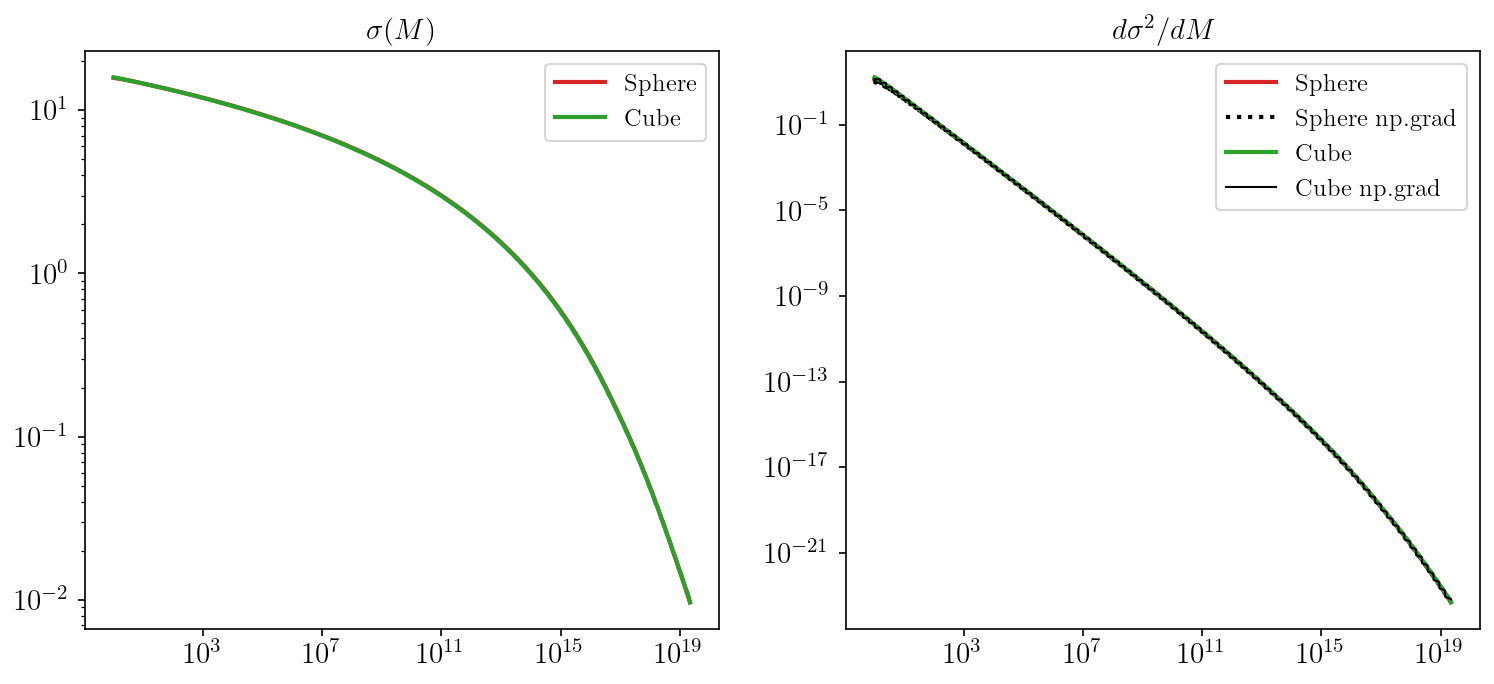

In [13]:
m_s = jnp.geomspace(M_MIN, RtoM(512), 4001)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
sigma_sphere = np.array([smi_sphere.sigma_z0(m) for m in m_s])
grad_ssq_sphere = np.gradient(sigma_sphere**2, m_s)
sigma_cube = np.array([smi_cube.sigma_z0(m) for m in m_s])
grad_ssq_cube = np.gradient(sigma_cube**2, m_s)

ax.plot(m_s, sigma_sphere, label="Sphere")
ax.plot(m_s, sigma_cube, label="Cube")
ax.set(xscale='log', yscale='log')
ax.set(title='$\sigma(M)$')
ax.legend()

ax = axs[1]
ax.plot(m_s, [-smi_sphere.dsigmasqdm_z0(m) for m in m_s], 'C0', label="Sphere")
ax.plot(m_s, - grad_ssq_sphere, 'k', ls=':', label="Sphere np.grad")
ax.plot(m_s, [-smi_cube.dsigmasqdm_z0(m) for m in m_s], 'C1', label="Cube")
ax.plot(m_s, - grad_ssq_cube, 'k', ls='-', lw=1, label="Cube np.grad")
ax.set(xscale='log', yscale='log')
ax.set(title='$d\sigma^2/dM$')
ax.legend()

# Press Schechter and Sheth Tormen Mass Functions

In [8]:
smi = smi_sphere

# This is the fitting function for the Dicke Linear Growth Factor. I took this from 21cmFAST
dicke_z_arr = jnp.linspace(0, 100, 1000)
omegaM_z_arr = cosmo.Om(dicke_z_arr)
def dicke(z):
    omegaM_z = jnp.interp(z, dicke_z_arr, omegaM_z_arr)
    
    dicke_z = 2.5 * omegaM_z / (1.0 / 70.0 + omegaM_z * (209 - omegaM_z) / 140.0 + omegaM_z**(4.0/7.0))
    dicke_0 = 2.5 * cosmo.Om0 / (1.0 / 70.0 + cosmo.Om0 * (209 - cosmo.Om0) / 140.0 + cosmo.Om0**(4.0/7.0))
    
    return dicke_z / (dicke_0 * (1.0 + z))

# This is the Sheth-Tormen Mass Function. This is exactly taken from 21cmFAST, which is why the conventions
# are a little bit weird. Anyways, this matches HMF precisely if the Sheth-Tormen parameteres are tuned
# to match those used by 21cmFAST.
@jit
def dNdM_st(M, z):
    growthf = dicke(z)
    sigma = smi.sigma_z0(M)
    dsigmadm = smi.dsigmasqdm_z0(M)
    sigma = sigma * growthf
    dsigmadm = dsigmadm * (growthf*growthf/(2.*sigma))
    nuhat = jnp.sqrt(SHETH_a) * Deltac / sigma
    return (-(cosmo.Om0)*rhoCrit0/M) * (dsigmadm/sigma) * jnp.sqrt(2./jnp.pi)*SHETH_A * (1+nuhat**(-2*SHETH_p)) * nuhat * jnp.exp(-nuhat*nuhat/2.0)

# This is the Press-Schechter Mass Function. This is taken exactly from 21cmFAST, which is why the conventions
# are a little bit weird. This precisely matches the HMF module.
@jit
def dNdM(M, z):
    growthf = dicke(z)
    sigma = smi.sigma_z0(M)
    dsigmadm = smi.dsigmasqdm_z0(M)
    sigma = sigma * growthf
    dsigmadm = dsigmadm * (growthf*growthf/(2.*sigma))
    return (-(cosmo.Om0)*rhoCrit0/M) * jnp.sqrt(2/jnp.pi) * (Deltac/(sigma*sigma)) * dsigmadm * jnp.exp(-(Deltac*Deltac)/(2*sigma*sigma))

# I had to implement this myself. I'm not actually sure 21cmFAST does this totally correctly, but I think this
# should be close enough. It comes from Eq. 7.81 in Galaxy 
# This is the conditional Press-Schechter
@jit
def dNdM_Conditional(MR, deltaR, z):
    
    delta2 = deltaR / dicke(z)
    delta1 = Deltac / dicke(z)
    
    S1 = smi.sigma_z0(smi.interp_m)**2
    S2 = smi.sigma_z0(MR)**2
    
    dS1_dM1 = smi.dsigmasqdm_z0(smi.interp_m)

    n12 = (delta1 - delta2) / jnp.sqrt(S1 - S2)
    differential = - smi.interp_m * (delta1-delta2) / 2 / n12 / jnp.sqrt(S1-S2)**3*dS1_dM1
    differential *= (S1 > S2)
    
    fPS = jnp.sqrt(2/jnp.pi)*n12*jnp.exp(-n12**2 / 2)
    
    return jnp.where(S1 > S2, 1 / smi.interp_m**2 * fPS * jnp.abs(differential), jnp.nan) * (cosmo.Om0*rhoCrit0)

# Load Annihilation Rates

In [9]:
# new ann rates
annihilation_dict = load_h5_dict("../../data/pwave/ann_rates_zm.h5")

annihilation_z = annihilation_dict['z_range']
annihilation_mass = annihilation_dict['m_range']
annihilation_rate = annihilation_dict['ann_rates']
# [ ] In GeV^2 / cm^3 / Mpc^3
# [X] In Msun(energy)^2 / pc^3 / Mpc^3
print(np.min(annihilation_rate), np.max(annihilation_rate))

1.6514133386913736e-15 7.195918224968385e+18


In [ ]:
# old ann rates
annihilation_dict = np.load('../../data/pwave/Annihilation_Dictionary.npz')

annihilation_z = annihilation_dict['z_range']
annihilation_mass = annihilation_dict['mass_range']
annihilation_rate = annihilation_dict['annihilation_rates']
print(np.min(annihilation_rate), np.max(annihilation_rate))

In [10]:
log_interpolator = interpolate.RegularGridInterpolator((annihilation_z, np.log10(annihilation_mass)),
                                                       np.log10(annihilation_rate),
                                                       bounds_error = False, 
                                                       fill_value = np.amin(np.log10(annihilation_rate)))

def annihilation_interpolator(z, M):
    m_in = np.atleast_1d(M)
    z_in = np.full(m_in.shape, z)
    zm_in = np.stack([z_in, np.log10(m_in)], axis=-1)
    return 10**log_interpolator(zm_in)

In [11]:
interpolated_annihilation_rates = np.zeros((len(annihilation_z), len(smi.interp_m)))

for i, z in enumerate(tqdm(annihilation_z)):
    interpolated_annihilation_rates[i] = annihilation_interpolator(z, smi.interp_m)

100%|██████████| 51/51 [00:00<00:00, 3472.50it/s]


# Generate HMF Tables for the Conditional Press-Schechter

In [14]:
z_range = annihilation_z
delta_range = np.linspace(-1, 1.5, 128)
r_range = np.geomspace(.1, 512, 128)

cond_dndm = np.zeros((len(z_range), len(delta_range), len(r_range), len(smi.interp_m)))

func = lambda r, d, z: jnp.nan_to_num(dNdM_Conditional(RtoM_cube(r), d, z))
func = jit(vmap(func, in_axes=(0, None, None)))

z = z_range[50]
d = delta_range[120]
r = r_range[120]
print(z, d, r)

np.trapz(interpolated_annihilation_rates[50] * func(jnp.array([r]), d, z), smi.interp_m) * unity.value

50.0 1.3622047244094486 319.758435507763


array([596602.34493225])

In [15]:
z_range = annihilation_z
delta_range = np.linspace(-1, 1.5, 128)
r_range = np.geomspace(.1, 512, 128)

cond_dndm = np.zeros((len(z_range), len(delta_range), len(r_range), len(smi.interp_m)))

func = lambda r, d, z: jnp.nan_to_num(dNdM_Conditional(RtoM_cube(r), d, z))
func = jit(vmap(func, in_axes=(0, None, None)))

for i, z in enumerate(tqdm(z_range)):
    for j, delta in enumerate(delta_range):
        cond_dndm[i, j, :] = func(r_range, delta, z)

100%|██████████| 51/51 [00:11<00:00,  4.28it/s]


In [16]:
cond_annihilation_table = np.zeros((len(z_range), len(delta_range), len(r_range)))

for i in tqdm(range(cond_annihilation_table.shape[0])):
    for j in range(cond_annihilation_table.shape[1]):
        for k in range(cond_annihilation_table.shape[2]):
            cond_annihilation_table[i,j,k] = np.trapz(interpolated_annihilation_rates[i] * cond_dndm[i,j,k], smi.interp_m)

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:22<00:00,  2.26it/s]


# Generate HMF for Unconditional Press-Schechter

In [17]:
print(np.min(cond_annihilation_table), np.max(cond_annihilation_table))
print(np.min(interpolated_annihilation_rates), np.max(interpolated_annihilation_rates))

1.8453645674592538e-14 27333.989200189317
1.6514133386913706e-15 7.123920077379552e+18


In [ ]:
print(np.min(cond_annihilation_table), np.max(cond_annihilation_table))
print(np.min(interpolated_annihilation_rates), np.max(interpolated_annihilation_rates))

1.2101701612732926e-14 27334.197902892356
1.6514133386913706e-15 7.123920077379552e+18


In [19]:
ps_annihilation_table = np.zeros((len(z_range)))

for i in range(ps_annihilation_table.shape[0]):
    ps_annihilation_table[i] = np.trapz(interpolated_annihilation_rates[i] * dNdM(smi.interp_m, z_range[i]), smi.interp_m)

In [ ]:
dNdM_table = []
dNdM_st_table = []
for z in z_range:
    dNdM_table.append(dNdM(smi.interp_m, z))
    dNdM_st_table.append(dNdM_st(smi.interp_m, z))
dNdM_table = np.array(dNdM_table)
dNdM_st_table = np.array(dNdM_st_table)

ps_m_data = {
    'z_range': z_range,
    'm_range': smi.interp_m,
    'm_range_units': 'Msun',
    'annihilation_rates': interpolated_annihilation_rates,
    'annihilation_rates_units': 'Msun^2 / pc^3',
    'dNdM': dNdM_table,
    'dNdM_st': dNdM_st_table,
    'dNdM_units': 'Msun^-1 Mpc^-3',
}

save_h5_dict('../../data/pwave/m_data.h5', ps_m_data)

(1e-40, 1802788027702443.0)

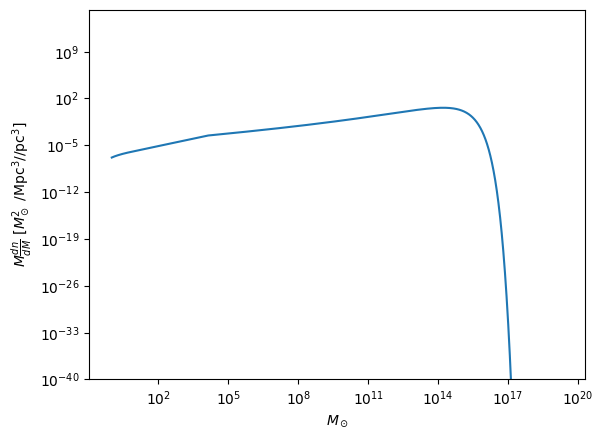

In [ ]:
plt.plot(smi.interp_m, smi.interp_m*dNdM(smi.interp_m, 0) * interpolated_annihilation_rates[0]) # Msun^2 / pc^3
plt.loglog()
plt.xlabel('$M_\odot$')
plt.ylabel(r'$M \frac{dn}{dM}$ [$M_\odot^2$ /Mpc$^3/$/pc$^{3}$]')
plt.ylim(1e-40, None)

# Generate HMF for Sheth-Tormen

In [20]:
st_annihilation_table = np.zeros((len(z_range)))

for i in range(ps_annihilation_table.shape[0]):
    st_annihilation_table[i] = np.trapz(interpolated_annihilation_rates[i] * dNdM_st(smi.interp_m, z_range[i]), smi.interp_m)

# Save the Results

In [13]:
unity =  1 * (c.M_sun**2 * c.c**4 / (u.pc**3 * u.Mpc**3)).to(u.eV**2 / u.cm**3 / u.cm**3)
print(unity.value)

1441.3537210485738


In [22]:
data_sph = load_h5_dict("../../data/pwave/pwave_ann_rate_o.h5")

In [26]:
cond_annihilation_table[0][60][60]

8.63552022651782

In [27]:
data_sph['ps_cond_ann_rate_table'][0][60][60] / unity.value

8.457259877441782

In [21]:
table_dict = {
    'z_range' : z_range,
    'd_range' : delta_range,
    'r_range' : r_range,
    'ps_cond_ann_rate_table' : cond_annihilation_table * unity.value,
    'ps_ann_rate_table' : ps_annihilation_table * unity.value,
    'st_ann_rate_table' : st_annihilation_table * unity.value,
}
save_dirs = [
    "/n/home07/yitians/dm21cm/DM21cm/data/pwave",
    "/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/data/zf002/data",
]
for save_dir in save_dirs:
    save_h5_dict(save_dir + f"/pwave_ann_rate_{smi.name}_v1regen.h5", table_dict)

In [52]:
cond_annihilation_table.shape, ps_annihilation_table.shape, st_annihilation_table.shape

((51, 128, 128), (51,), (51,))

# Comparison with old results

In [22]:
cmp = load_h5_dict("../../data/pwave/pwave_ann_rate_o.h5")
cmp.keys()

dict_keys(['delta_range', 'ps_ann_rate_table', 'ps_cond_ann_rate_table', 'r_range', 'st_ann_rate_table', 'z_range'])

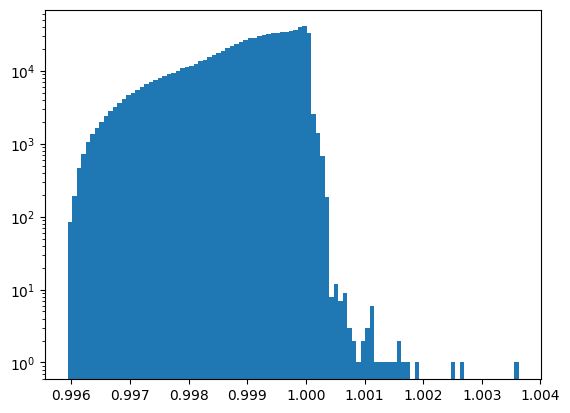

In [ ]:
z = cmp['ps_cond_ann_rate_table'] / table_dict['ps_cond_ann_rate_table']
plt.hist(z.flatten(), bins=100)
plt.yscale('log')

# Archive

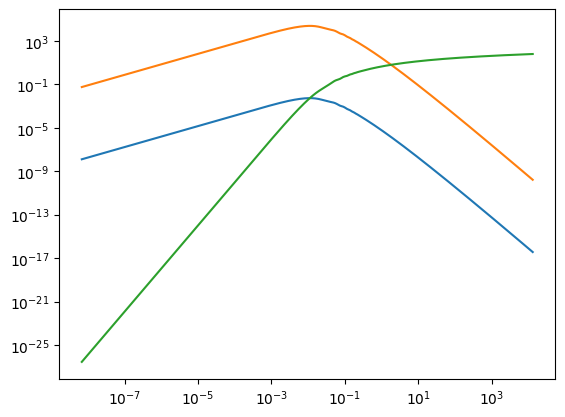

In [ ]:
interp_k = tr.k * cosmo.h # to u without `h`
interp_T = tr.transfer_function / np.amax(tr.transfer_function) # normalized
interp_P = interp_k**2 * interp_T**2 * interp_k**cosmo.to_format('mapping')['meta']['n']

plt.plot(interp_k, interp_P/interp_k**2)
plt.plot(interp_k, tr.power)
plt.plot(interp_k, tr.delta_k)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e0, None)

## A. Cube integration

In [ ]:
np.sqrt(10)

3.1622776601683795

In [ ]:
resolution = 10000
lklb = np.log(interp_k[0])
lkub = np.log(interp_k[-1])
lk_s = jnp.linspace(jnp.log(interp_k[0]), jnp.log(interp_k[-1]), resolution)
k_s = jnp.exp(lk_s)

def integrand_3(lkx, lky, lkz):
    kx, ky, kz = jnp.exp(lkx), jnp.exp(lky), jnp.exp(lkz)
    k = jnp.sqrt(kx**2 + ky**2 + kz**2)
    return kx * ky * kz * k2P_unnorm(k) * W(kx, ky, kz, Radius_8)**2

def integrand_2(lkx, lky):
    return jnp.trapz(k_s * integrand_3(lkx, lky, lk_s), lk_s)

@jit
def integrand_1(lkx):
    return jnp.trapz(k_s * vmap(integrand_2, (None, 0))(lkx, lk_s), lk_s)

def integral():
    integrand = []
    for lk in tqdm(lk_s):
        integrand.append(integrand_1(lk))
    integrand = jnp.asarray(integrand)
    return jnp.trapz(k_s * integrand, lk_s)

print(integral())

100%|██████████| 10000/10000 [11:17<00:00, 14.75it/s]


2.7448218808073346e-09


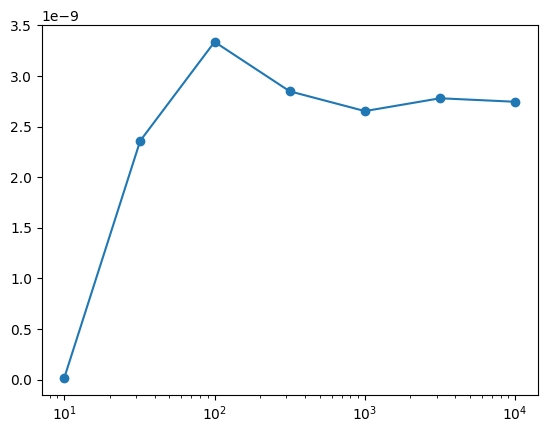

In [ ]:
a = [10, 32, 100, 316, 1000, 3162, 10000]
b = [1.8247880587527738e-11, 2.3588969428981962e-09, 3.3362717953372406e-09, 2.8484186491494225e-09, 2.6527731963891473e-09, 2.7794302923913358e-09, 2.7448218808073346e-09]
plt.plot(a, b, 'o-')
plt.xscale('log')